## Prepare for learning

In [ ]:
from google.colab import drive
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy import ndimage
import time
from sklearn.neighbors import KNeighborsClassifier

### Load Dataset

In [ ]:
drive.mount('/content/drive')
mat = sio.loadmat('/content/drive/MyDrive/face.mat')

imgs_raw = mat['X']
labels = mat['l'][0]
print(imgs_raw.shape, labels.shape)

Mounted at /content/drive
(2576, 520) (520,)


In [ ]:
imgs = [img_raw.reshape((46,56)) for img_raw in imgs_raw.T]

In [ ]:
# num_row means the number of classes you want to see, and num_col(<=10) means the number of images you want to see in each class
def plot_imgs(imgs, num_row, num_col, max_col):
  fig, ax = plt.subplots(num_row, num_col, figsize=(10,10))
  ax = ax.flatten()
  for i in range(num_row):
    for j in range(num_col):
      ax[i*num_col+j].imshow(imgs[i*max_col+j].T, cmap = 'gist_gray')
      ax[i*num_col+j].axis('off')
  plt.tight_layout()
  plt.show()

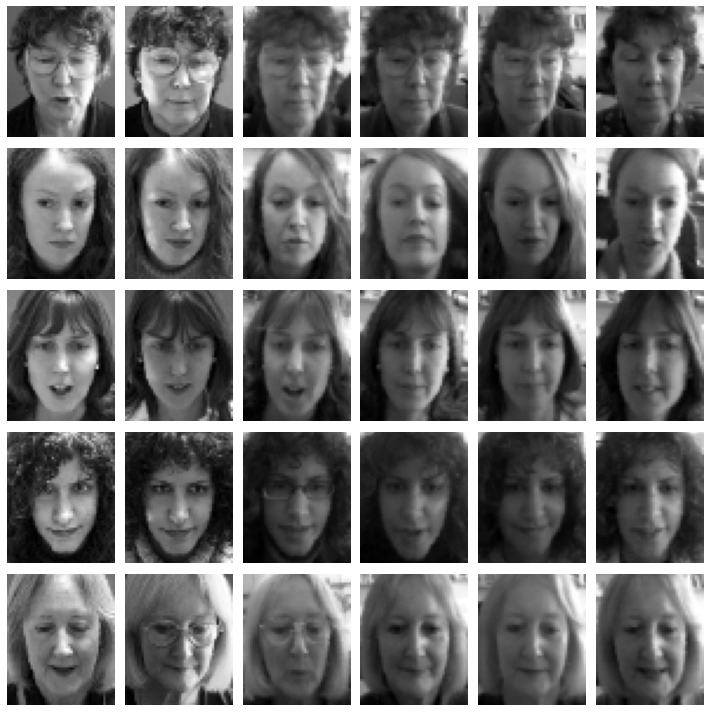

In [ ]:
plot_imgs(imgs, 5, 6, 10)

### Split data into train dataset and test dataset(8:2)

In [ ]:
train_idx = np.array([[True]*10]*52)
for i in train_idx:
  test_idx_tmp = np.random.choice(10, size=2, replace=False)
  i[test_idx_tmp]=False
train_idx = train_idx.flatten()
test_idx = ~ train_idx

train_imgs_raw = np.array([i[train_idx] for i in imgs_raw])
test_imgs_raw = np.array([i[test_idx] for i in imgs_raw])
train_labels = labels[train_idx]
test_labels = labels[test_idx]

print("Data Dimension")
print("train_imgs_raw : ", len(train_imgs_raw)," * ", len(train_imgs_raw[0]))
print("test_imgs_raw  : ", len(test_imgs_raw)," * ",  len(test_imgs_raw[0]))
print("train_labels : ", len(train_labels))
print("test_labels  : ", len(test_labels))

Data Dimension
train_imgs_raw :  2576  *  416
test_imgs_raw  :  2576  *  104
train_labels :  416
test_labels  :  104


## 1. Computationally Efficient Eigenfaces

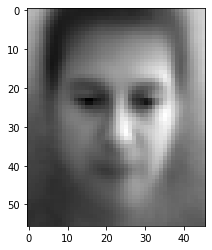

In [ ]:
'''
mean face
'''
avg_img = np.mean(train_imgs_raw, axis=1)
plt.imshow(avg_img.reshape(46,56).T, cmap = 'gist_gray')

In [ ]:
'''
PCA
use np.linalg.eigh instead of np.linalg.eig because S is symmetric
w means eigenvalues, v means eigenvectors
'''

A = (train_imgs_raw.T-avg_img).T
S_high = np.dot(A, A.T) # covariance matrix
S_low = np.dot(A.T, A)
# print(S_high.shape, S_low.shape)

start_high = time.time()
w_high, v_high = np.linalg.eigh(S_high)
stop_high = time.time()
start_low = time.time()
w_low, v_low = np.linalg.eigh(S_low)
stop_low = time.time()

print(f"Training time for high dimension is {stop_high-start_high}\nTraining time for low dimension is {stop_low-start_low}")

Training time for high dimension is 3.4771058559417725
Training time for low dimension is 0.03111743927001953


In [ ]:
v_high = v_high.T
v_low_to_high = np.dot(A, v_low)
v_low_to_high = v_low_to_high/np.linalg.norm(v_low_to_high, axis=0)
v_low_to_high = v_low_to_high.T
# print(v_high[-M:])
print(max(w_high[w_high<1]), min(w_high[w_high>1]))
print(max(w_low[w_low<1]), min(w_low[w_low>1]))
print(f"Number of non-zero eigenvalues of high dimension is {np.count_nonzero(w_high>1)}\nNumber of non-zero eigenvalues of low dimension is {np.count_nonzero(w_low>1)}")

8.458461553074908e-08 35791.10917225052
6.038265948949507e-09 35791.109172249315
Number of non-zero eigenvalues of high dimension is 415
Number of non-zero eigenvalues of low dimension is 415


In [ ]:
print("Are all the M largest eigenvalues the same?", np.allclose(w_high[w_high>1], w_low[w_low>1]))
print("Therefore, w_high==w_low")

Are all the M largest eigenvalues the same? True
Therefore, w_high==w_low


In [ ]:
M=200
v_ratio = v_high[-M:]/v_low_to_high[-M:]
v_final = v_high[-M:]
print("Are all the corresponding eigenvectors of the M non-trivial eigenvalues the same?", np.allclose(np.max(v_ratio, axis=1), np.min(v_ratio, axis=1)))
print("Therefore, v_high==v_low")

Are all the corresponding eigenvectors of the M non-trivial eigenvalues the same? True
Therefore, v_high==v_low


In [ ]:
import plotly.express as px
sorted_w_high = sorted(w_high, reverse=True)
sorted_w_low = sorted(w_low, reverse=True)
chartInfo = []
for i in range(np.count_nonzero(w_high>1)):
  chartInfo.append({"value": sorted_w_high[i], "ith_largest": i, "version": "with higher dim"})
  chartInfo.append({"value": sorted_w_low[i], "ith_largest": i, "version": "with lower dim"})
px.line(chartInfo, x="ith_largest", y="value", facet_col="version")

In [ ]:
'''
reconstruction and kNN classifier test
'''
train_reconst_imgs, test_reconst_imgs, train_error, test_error = [], [], None, None
reconstructionErrorChartInfo = []
scoreChartInfo = []

for m in [10, 30, 50, 100, 150, 200]:
  print(f"Where M = {m}...")
  start_time = time.time()
  v_final = v_high[-m:]

  train_proj = np.dot((train_imgs_raw.T-avg_img), v_final.T)
  test_proj = np.dot((test_imgs_raw.T-avg_img), v_final.T)

  for i in range(1, 10):
    classifier = KNeighborsClassifier(n_neighbors = i)
    classifier.fit(train_proj, train_labels)

    train_score = classifier.score(train_proj, train_labels)
    test_score = classifier.score(test_proj, test_labels)

    scoreChartInfo.append({"KNN Classifier Score": train_score, "M": m, "k": i, "version": "train"})
    scoreChartInfo.append({"KNN Classifier Score": test_score, "M": m, "k": i, "version": "test"})
    
    print(f"For {i}NN classifier, train score is {train_score} and test score is {test_score}")

  train_reconst = np.dot(train_proj, v_final) + avg_img
  test_reconst = np.dot(test_proj, v_final) + avg_img
  train_reconst_imgs.append(train_reconst)
  test_reconst_imgs.append(test_reconst)

  train_error = np.mean(np.linalg.norm(train_reconst-train_imgs_raw.T, axis = 1))
  test_error = np.mean(np.linalg.norm(test_reconst-test_imgs_raw.T, axis = 1))

  end_time = time.time()
  time_spent = end_time - start_time
  reconstructionErrorChartInfo.append({"Reconstruction Error": train_error, "M": m, "Time Taken": time_spent, "version": "train"})
  reconstructionErrorChartInfo.append({"Reconstruction Error": test_error, "M": m, "Time Taken": time_spent, "version": "test"})

  print(f">>>Reconstruction train error is {train_error}\n>>>Reconstruction test error is {test_error}\n>>>Time taken: {time_spent}s\n")

Where M = 10...
For 1NN classifier, train score is 1.0 and test score is 0.3942307692307692
For 2NN classifier, train score is 0.6850961538461539 and test score is 0.36538461538461536
For 3NN classifier, train score is 0.6153846153846154 and test score is 0.36538461538461536
For 4NN classifier, train score is 0.5865384615384616 and test score is 0.3173076923076923
For 5NN classifier, train score is 0.5552884615384616 and test score is 0.28846153846153844
For 6NN classifier, train score is 0.5240384615384616 and test score is 0.2692307692307692
For 7NN classifier, train score is 0.5 and test score is 0.25961538461538464
For 8NN classifier, train score is 0.49278846153846156 and test score is 0.28846153846153844
For 9NN classifier, train score is 0.4735576923076923 and test score is 0.27884615384615385
>>>Reconstruction train error is 1206.1376286112668
>>>Reconstruction test error is 1210.2256711240773
>>>Time taken: 0.24251818656921387s

Where M = 30...
For 1NN classifier, train score 

Images below are the original image and reconstructed ones,
where the reconstructed ones are ordered by its M values (M=10, 30, 50, 100, 150, 200 respectively)


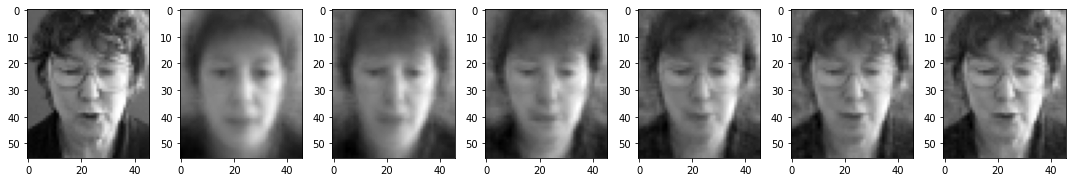

In [ ]:
print('''Images below are the original image and reconstructed ones,
where the reconstructed ones are ordered by its M values (M=10, 30, 50, 100, 150, 200 respectively)''')

fig, ax = plt.subplots(1, 7, figsize=(15,15))
ax = ax.flatten()
m_list = [10, 30, 50, 100, 150, 200]
ax[0].imshow(imgs[0].reshape(46,56).T, cmap = 'gist_gray')
for i in range(6):
  # reconstructed image of the very first face, where M = m_list[i]
  ax[i+1].imshow(train_reconst_imgs[i][0].reshape(46,56).T, cmap = 'gist_gray')
plt.tight_layout()
plt.show()

Where M = 10...
Images below are reconstructed train images


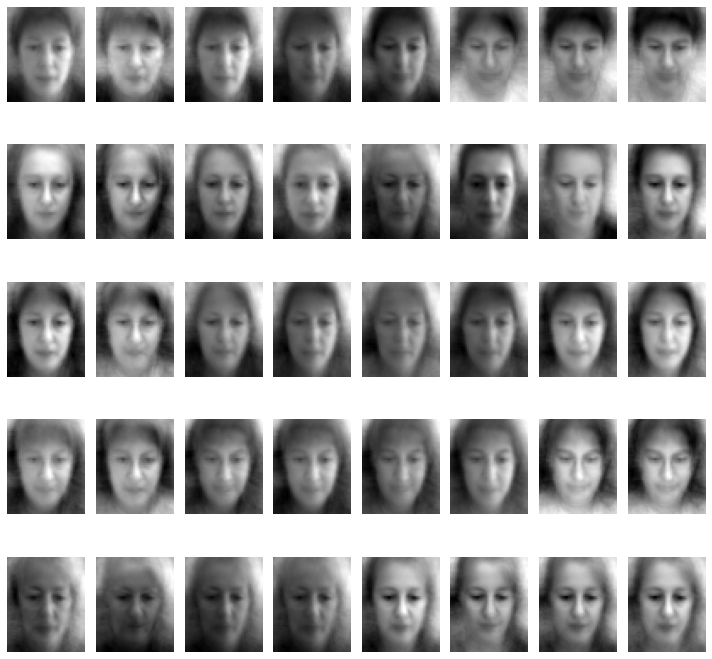

Images below are reconstructed test images


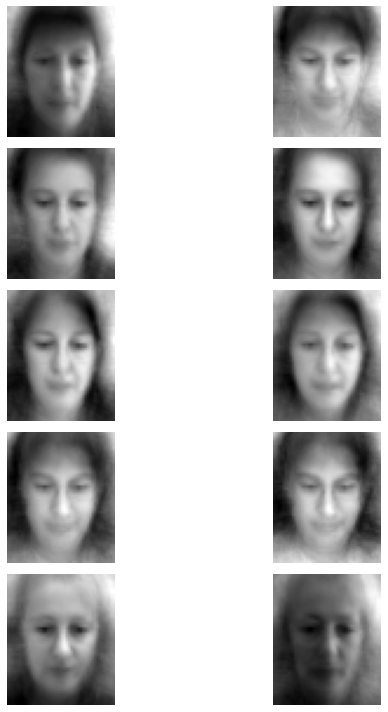

Where M = 30...
Images below are reconstructed train images


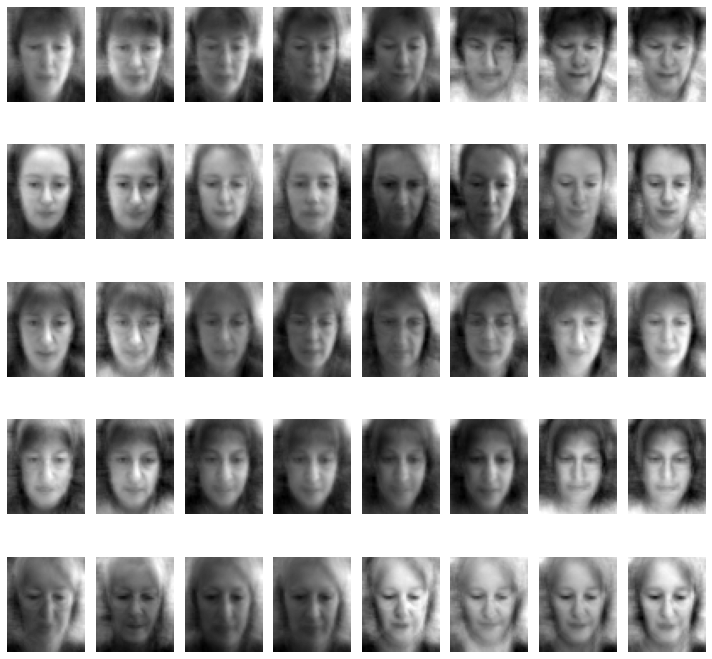

Images below are reconstructed test images


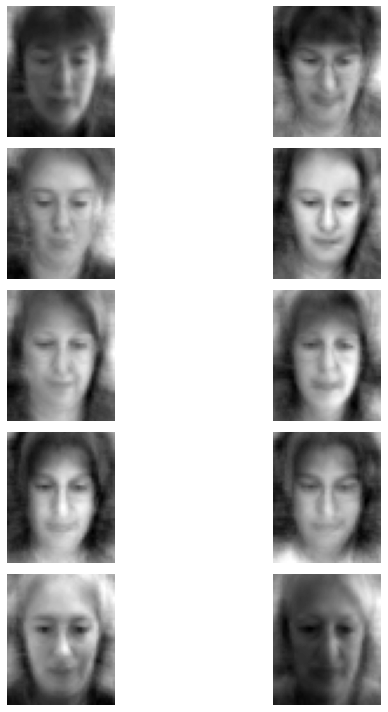

Where M = 50...
Images below are reconstructed train images


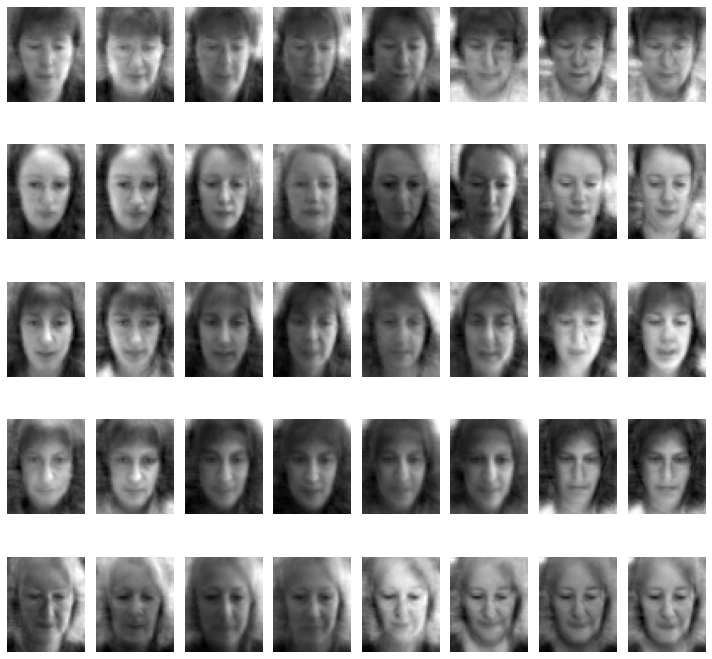

Images below are reconstructed test images


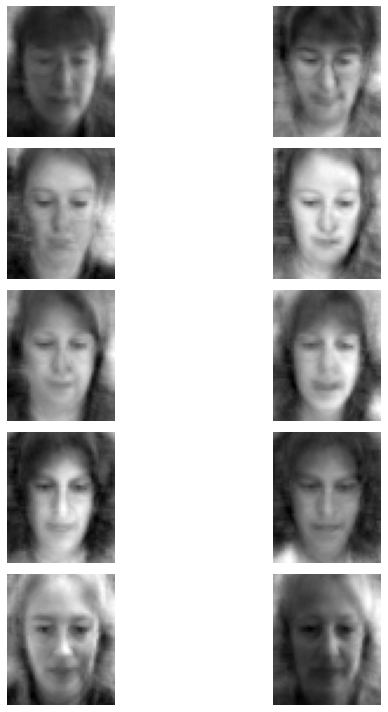

Where M = 100...
Images below are reconstructed train images


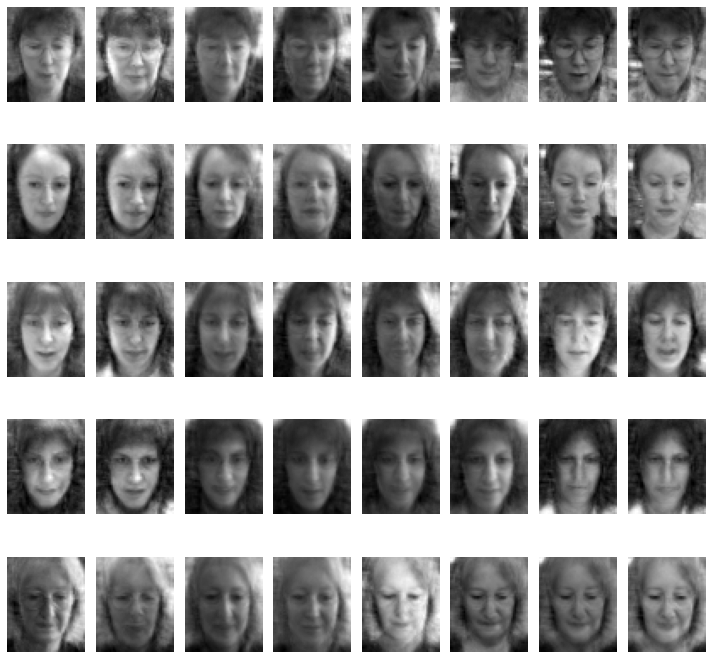

Images below are reconstructed test images


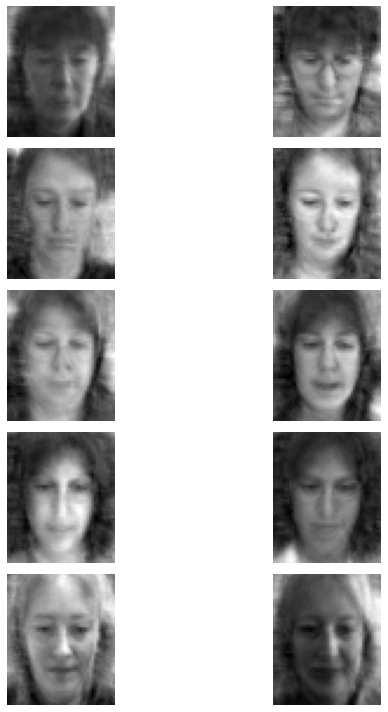

Where M = 150...
Images below are reconstructed train images


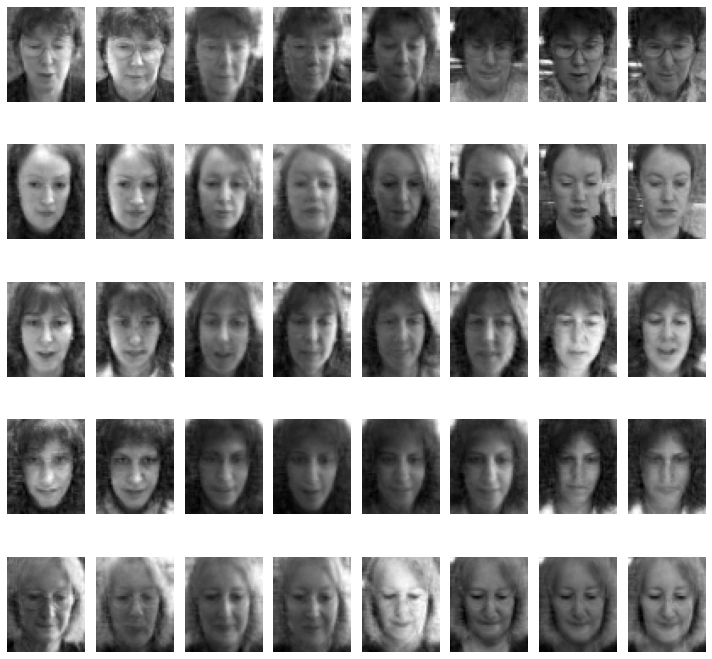

Images below are reconstructed test images


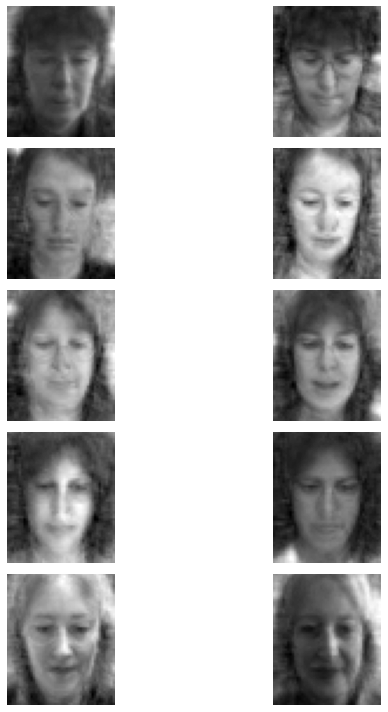

Where M = 200...
Images below are reconstructed train images


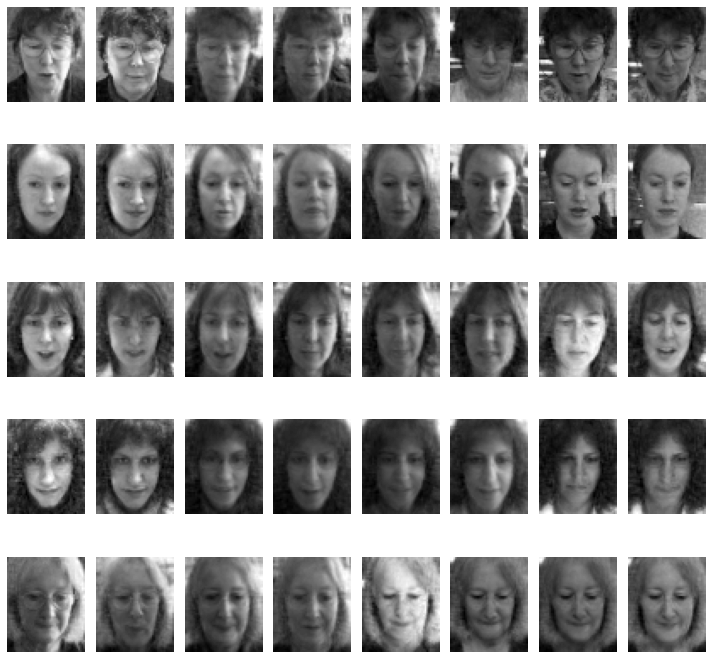

Images below are reconstructed test images


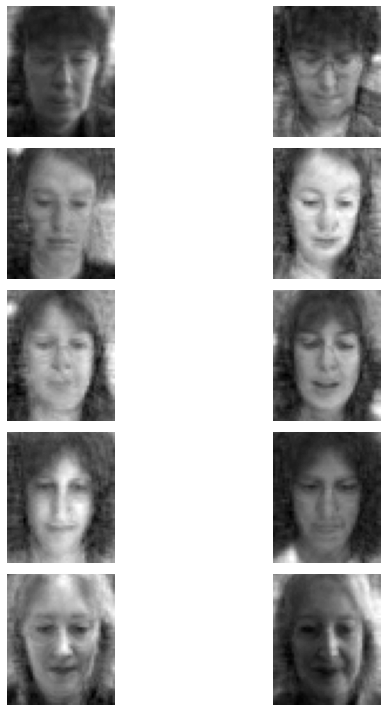

In [ ]:
m_list = [10, 30, 50, 100, 150, 200]
for i in range(6):
  print(f"Where M = {m_list[i]}...")
  print("Images below are reconstructed train images")
  plot_imgs([img_raw.reshape((46,56)) for img_raw in train_reconst_imgs[i]], 5, 8, 8)
  print("Images below are reconstructed test images")
  plot_imgs([img_raw.reshape((46,56)) for img_raw in test_reconst_imgs[i]], 5, 2, 2)

In [ ]:
timeChartInfo = [info for info in reconstructionErrorChartInfo if info["version"]]
px.line(timeChartInfo, x="M", y="Time Taken")

In [ ]:
px.line(reconstructionErrorChartInfo, x="M", y="Reconstruction Error", color="version")

In [ ]:
px.line(scoreChartInfo, x="k", y="KNN Classifier Score", color="M", facet_col="version")

### kNN classifier error examples for k=1

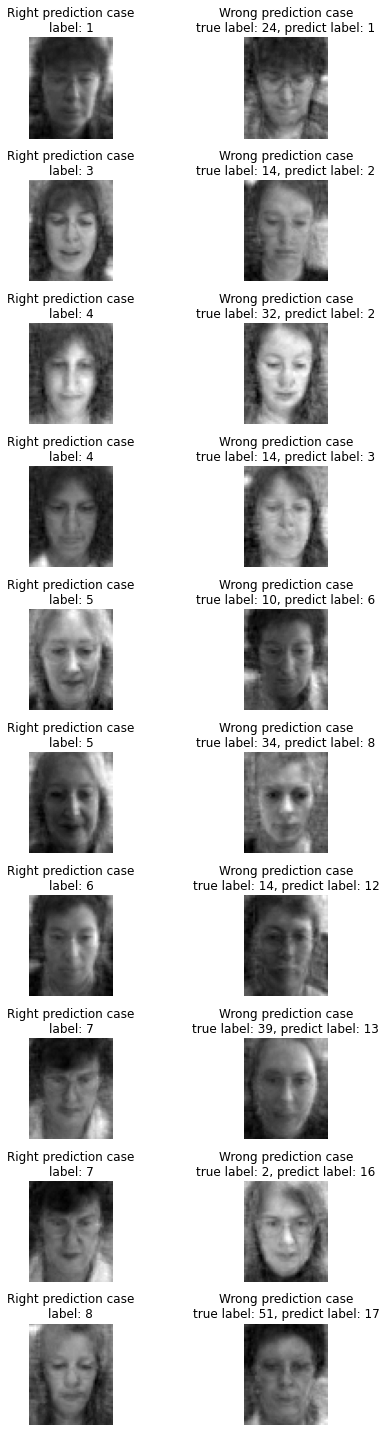

In [ ]:
train_proj = np.dot((train_imgs_raw.T-avg_img), v_final.T)
test_proj = np.dot((test_imgs_raw.T-avg_img), v_final.T)

classifier = KNeighborsClassifier(n_neighbors = 1)
classifier.fit(train_proj, train_labels)

test_pred_labels = classifier.predict(test_proj)
test_reconst = np.dot(test_proj, v_final) + avg_img

num = 10
num_right, num_wrong = num, num

right = []
wrong = []

idx=0
while((num_right!=0 or num_wrong!=0) and idx<test_pred_labels.shape[0]):
  if(test_pred_labels[idx]==test_labels[idx] and num_right!=0):
    append = (test_reconst[idx].reshape((46,56)).T, test_pred_labels[idx])
    right.append(append)
    num_right-=1
  if(test_pred_labels[idx]!=test_labels[idx] and num_wrong!=0):
    append = (test_reconst[idx].reshape((46,56)).T, test_pred_labels[idx], test_labels[idx])
    wrong.append(append)
    num_wrong-=1
  idx+=1

fig, ax = plt.subplots(nrows=10, ncols=2, figsize=(20,20))
ax = ax.flatten()
for i in range(len(wrong)):
  ax[i*2].imshow(right[i][0], cmap = 'gist_gray')
  ax[i*2].axis('off')
  ax[i*2].set_title(f"Right prediction case\nlabel: {right[i][1]}")
  ax[i*2+1].imshow(wrong[i][0], cmap = 'gist_gray')
  ax[i*2+1].axis('off')
  ax[i*2+1].set_title(f"Wrong prediction case\ntrue label: {wrong[i][1]}, predict label: {wrong[i][2]}")
plt.tight_layout()
plt.subplots_adjust(right=0.4)
plt.show()